# Transfer learning na zbiorze Cats vs Dogs

## 1. Wprowadzenie

W tym notatniku przeanalizujemy klasyfikację binarną obrazów kotów i psów.  
Porównamy dwa podejścia:
1. **Uczenie od zera (baseline)** – mała, własna sieć CNN trenowana na bardzo małym zbiorze (np. 10 kotów i 10 psów),
2. **Transfer learning** – wykorzystanie wcześniej wytrenowanych modeli (MobileNetV2, VGG16, ResNet50) opartych o dane **ImageNet**.

Celem jest pokazanie, że **transfer learning pozwala osiągnąć lepsze wyniki nawet przy minimalnej liczbie danych treningowych**.

---

## 2. Czym jest ImageNet

**ImageNet** to ogromna, otwarta baza danych obrazów przeznaczona do trenowania i ewaluacji modeli rozpoznawania obrazów.  
Zawiera ponad **14 milionów obrazów** podzielonych na **około 20 tysięcy kategorii** (np. zwierzęta, pojazdy, obiekty codziennego użytku).  
Obrazy są pogrupowane według hierarchii WordNet, dzięki czemu modele uczą się rozpoznawać nie tylko konkretne obiekty, ale też zależności między klasami.

Link do oficjalnej strony projektu:  
🔗 [https://image-net.org](https://image-net.org)

Modele takie jak **VGG16**, **ResNet50**, czy **MobileNetV2** zostały pierwotnie wytrenowane właśnie na ImageNet, co oznacza, że:
- rozpoznają bardzo ogólne cechy wizualne (krawędzie, kolory, tekstury, kształty),
- potrafią ekstraktować uniwersalne reprezentacje obrazu.

Te „nauczone wcześniej” warstwy możemy ponownie wykorzystać w nowych zadaniach, nawet jeśli liczba danych jest bardzo mała.

---

## 3. Idea transfer learningu

**Transfer learning** (uczenie przez przeniesienie) to metoda, w której:
- bierzemy **gotowy, wytrenowany model** (np. ResNet50 z wagami z ImageNet),
- usuwamy jego końcową część (warstwę klasyfikującą 1000 klas ImageNet),
- **zamrażamy** pozostałe warstwy (tzw. feature extractor),
- dodajemy własną warstwę klasyfikacyjną dopasowaną do naszego problemu (np. 2 klasy: „kot” i „pies”),
- trenujemy tylko nową część lub delikatnie dostrajamy cały model (fine-tuning).

Dzięki temu:
- model korzysta z już „nauczonych” cech wizualnych,
- nie potrzebujemy dużego zbioru danych,
- proces uczenia jest szybszy i stabilniejszy.

---

## 4. Porównanie z uczeniem od zera

| Cecha | Uczenie od zera | Transfer learning |
|-------|-----------------|-------------------|
| Dane potrzebne | Dużo (tysiące lub miliony przykładów) | Niewiele (dziesiątki lub setki) |
| Czas treningu | Długi | Krótszy |
| Wymagana moc obliczeniowa | Wysoka | Niższa |
| Ryzyko overfittingu | Duże przy małym zbiorze | Mniejsze |
| Ogólność cech | Ograniczona do zbioru | Bardzo dobra – model zna ogólne cechy obrazów |

---

## 5. Matematyczna intuicja

Niech $f_{\text{base}}(x; \theta)$ będzie częścią sieci wytrenowaną na ImageNet, a $g(x; \phi)$ – nową warstwą klasyfikującą uczoną na naszym zbiorze.  
Transfer learning polega na tym, że nie uczymy $\theta$ od nowa, lecz tylko dostrajamy $\phi$:

$$
\text{Model końcowy: } \hat{y} = g(f_{\text{base}}(x; \theta_{\text{ImageNet}}); \phi)
$$

Podczas trenowania minimalizujemy funkcję straty np. **binary crossentropy**:
$$
L = -[y \log(\hat{y}) + (1-y)\log(1-\hat{y})]
$$
gdzie $y \in \{0,1\}$ (kot lub pies).

---

## 6. Modele wykorzystane w notatniku

W tym projekcie porównamy trzy popularne architektury sieci konwolucyjnych:

1. **MobileNetV2**  
   Lekka sieć zaprojektowana do szybkiego działania na urządzeniach mobilnych.  
   Cechuje się bardzo małą liczbą parametrów przy zachowaniu dobrej dokładności.

2. **VGG16**  
   Klasyczna głęboka sieć z 16 warstwami konwolucyjnymi.  
   Charakteryzuje się prostą strukturą (konwolucje 3×3 + max pooling).

3. **ResNet50**  
   Sieć rezydualna – zawiera tzw. „shortcut connections”, które zapobiegają zanikaniu gradientów i pozwalają trenować bardzo głębokie sieci.  
   Blok rezydualny można zapisać jako:
   $$
   \mathbf{y} = F(\mathbf{x}, W_i) + \mathbf{x}
   $$
   gdzie $F(\mathbf{x}, W_i)$ to transformacja wejścia $\mathbf{x}$, a dodanie $\mathbf{x}$ (shortcut) stabilizuje uczenie.

---

## 7. Zbiór danych: Cats vs Dogs

Zbiór **Cats vs Dogs** pochodzi z konkursu Kaggle, a jego wersja uproszczona jest dostępna w TensorFlow.

- Kategorie: `cats`, `dogs`
- Około 20 000 obrazów (po ok. 10 000 na klasę)
- Rozdzielczość: różna (obrazy kolorowe RGB)
- Typ zadania: klasyfikacja binarna

Link do oryginalnego zestawu:
🔗 [https://www.kaggle.com/c/dogs-vs-cats/data](https://www.kaggle.com/c/dogs-vs-cats/data)

---

## 8. Plan eksperymentu

1. Wczytamy dane i zbudujemy bardzo mały zbiór treningowy: **10 kotów i 10 psów**.
2. Nauczymy prostą sieć CNN od zera (baseline) i sprawdzimy jej skuteczność.
3. Następnie użyjemy **transfer learning** z trzema modelami:
   - MobileNetV2,
   - VGG16,
   - ResNet50.
4. Porównamy wyniki i pokażemy, że modele z wagami z ImageNet dają lepsze rezultaty nawet przy minimalnej liczbie danych.

---

## 9. Oczekiwany efekt

Dzięki transfer learningowi:
- model będzie uczył się szybciej,  
- dokładność wzrośnie w porównaniu do baseline’u,  
- krzywa walidacji będzie stabilniejsza,  
- a macierz pomyłek pokaże mniej błędnych klasyfikacji.

---


In [4]:
# ============================================================
# 1. IMPORTY
# ============================================================
import os
import zipfile
import pathlib
import shutil

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# do oceny
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

print(tf.__version__)


2.20.0


In [6]:
# ============================================================
# CHECK NUMPY VERSION
# ============================================================
import numpy as np
print(f"NumPy version: {np.__version__}")

# Also check other key packages
try:
    import tensorflow as tf
    print(f"TensorFlow version: {tf.__version__}")
except ImportError:
    print("TensorFlow not installed")

try:
    import sklearn
    print(f"Scikit-learn version: {sklearn.__version__}")
except ImportError:
    print("Scikit-learn not installed")

try:
    import matplotlib
    print(f"Matplotlib version: {matplotlib.__version__}")
except ImportError:
    print("Matplotlib not installed")

NumPy version: 2.3.5
TensorFlow version: 2.20.0
Scikit-learn version: 1.8.0
Matplotlib version: 3.10.8


In [7]:
# ============================================================
# 2. POBRANIE I ROZPAKOWANIE ZBIORU CATS vs DOGS (wersja tf)
# źródło: https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
# ============================================================
url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"

# pobieramy zip
#zip_path = keras.utils.get_file("cats_and_dogs_filtered.zip", origin=url, extract=False)

import kagglehub

# Download latest version
path = kagglehub.dataset_download("birajsth/cats-and-dogs-filtered")

print("Path to dataset files:", path)


# rozpakowujemy do bieżącego katalogu
# with zipfile.ZipFile(zip_path, 'r') as z:
#     z.extractall(".")

# główny katalog z danymi
base_dir = pathlib.Path(path+"/cats_and_dogs_filtered")
train_dir = base_dir / "train"
val_dir = base_dir / "validation"

print("train_dir:", train_dir)
print("val_dir:", val_dir)
print("cats train:", len(os.listdir(train_dir / "cats")))
print("dogs train:", len(os.listdir(train_dir / "dogs")))


c:\Users\jakub\workspace\SWPS_2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\jakub\.cache\kagglehub\datasets\birajsth\cats-and-dogs-filtered\versions\1
train_dir: C:\Users\jakub\.cache\kagglehub\datasets\birajsth\cats-and-dogs-filtered\versions\1\cats_and_dogs_filtered\train
val_dir: C:\Users\jakub\.cache\kagglehub\datasets\birajsth\cats-and-dogs-filtered\versions\1\cats_and_dogs_filtered\validation
cats train: 1000
dogs train: 1000


In [37]:
# ============================================================
# 3. ZROBIENIE BARDZO MAŁEGO ZBIORU: 10 kotów + 10 psów do treningu,
#    i np. 5 + 5 do walidacji
#    (żeby pokazać, że własna CNN ma problemy)
# ============================================================

small_base = pathlib.Path("small_cats_dogs")
small_train = small_base / "train"
small_val = small_base / "val"

# jeśli wcześniej już było – czyścimy
if small_base.exists():
    shutil.rmtree(small_base)

# tworzymy strukturę katalogów
(small_train / "cats").mkdir(parents=True, exist_ok=True)
(small_train / "dogs").mkdir(parents=True, exist_ok=True)
(small_val / "cats").mkdir(parents=True, exist_ok=True)
(small_val / "dogs").mkdir(parents=True, exist_ok=True)

def copy_n(src_dir, dst_dir, n):
    """kopiuje n pierwszych obrazów z src_dir do dst_dir"""
    imgs = sorted(os.listdir(src_dir))[:n]
    for img in imgs:
        shutil.copy(src_dir / img, dst_dir / img)

# 10 + 10 na train
copy_n(train_dir / "cats", small_train / "cats", 100)
copy_n(train_dir / "dogs", small_train / "dogs", 100)

# 5 + 5 na val
copy_n(val_dir / "cats", small_val / "cats", 5)
copy_n(val_dir / "dogs", small_val / "dogs", 5)

print("Utworzono mały zbiór w:", small_base)
print("train cats:", len(os.listdir(small_train / "cats")))
print("train dogs:", len(os.listdir(small_train / "dogs")))
print("val cats:", len(os.listdir(small_val / "cats")))
print("val dogs:", len(os.listdir(small_val / "dogs")))


Utworzono mały zbiór w: small_cats_dogs
train cats: 100
train dogs: 100
val cats: 5
val dogs: 5


In [63]:
# ============================================================
# 4. GENERATORY DANYCH
# użyjemy ImageDataGenerator, bo dane mamy w katalogach
# ============================================================

img_size = (160, 160)  # typowy rozmiar dla małych modeli
batch_size = 4         # mały batch, bo mało danych

train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen_small = train_datagen.flow_from_directory(
    small_train,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary"
)

val_gen_small = val_datagen.flow_from_directory(
    small_val,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False   # przy walidacji/lub testach – bez tasowania
)

print("mapa klas:", train_gen_small.class_indices)


Found 200 images belonging to 2 classes.
Found 12 images belonging to 2 classes.
mapa klas: {'cats': 0, 'dogs': 1}


In [64]:
# ============================================================
# 5. BASELINE – PROSTA CNN „JAK MNIST TYLKO WIĘKSZA”
# ============================================================

baseline_model = keras.Sequential([
    # blok 1
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=img_size + (3,)),
    layers.MaxPooling2D((2, 2)),

    # blok 2
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    # klasyfikator
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # binarna klasyfikacja
])

baseline_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

baseline_model.summary()


c:\Users\jakub\workspace\SWPS_2\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 92416)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │    11,829,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,848,897 (45.20 MB)

 Trainable params: 11,848,897 (45.20 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# ============================================================
# 6. TRENING BASELINE
# (na tak małej liczbie obrazów będzie się „uczył” za dobrze na train,
#  ale słabo generalizował)
# ============================================================

history_baseline = baseline_model.fit(
    train_gen_small,
    epochs=100,
    validation_data=val_gen_small,
    verbose=1
)


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.6000 - val_loss: 2.0581
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 1.0000 - loss: 7.4153e-04 - val_accuracy: 0.5000 - val_loss: 2.4283
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 1.0000 - loss: 4.1870e-04 - val_accuracy: 0.5000 - val_loss: 2.4044
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 1.0000 - loss: 1.6948e-04 - val_accuracy: 0.5000 - val_loss: 2.4427
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 1.0000 - loss: 1.0018e-04 - val_accuracy: 0.5000 - val_loss: 2.4636
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 1.0000 - loss: 6.7600e-05 - val_accuracy: 0.5000 - val_loss: 2.4585
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 1.0000 - loss: 4.7353e-05 - val_accuracy: 0.5000 - val_loss: 2.4569
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 1.0000 - loss: 3

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


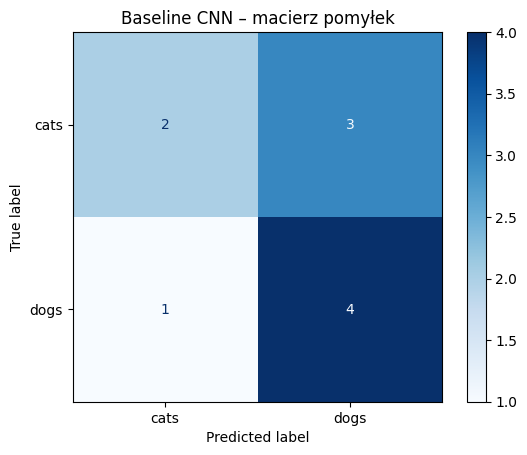

=== Baseline – classification report ===
              precision    recall  f1-score   support

        cats       0.67      0.40      0.50         5
        dogs       0.57      0.80      0.67         5

    accuracy                           0.60        10
   macro avg       0.62      0.60      0.58        10
weighted avg       0.62      0.60      0.58        10



In [43]:
# ============================================================
# 7. EWALUACJA BASELINE – MACIERZ POMYŁEK
# ============================================================

# prawdziwe etykiety z generatora walidacyjnego
val_gen_small.reset()
y_true = val_gen_small.classes

# przewidywania
y_pred_proba = baseline_model.predict(val_gen_small)
y_pred = (y_pred_proba > 0.5).astype("int32").flatten()

cm_base = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_base,
                              display_labels=val_gen_small.class_indices.keys())
disp.plot(cmap="Blues")
plt.title("Baseline CNN – macierz pomyłek")
plt.show()

print("=== Baseline – classification report ===")
print(classification_report(y_true, y_pred, target_names=val_gen_small.class_indices.keys()))


In [66]:
# ============================================================
# 8. TRANSFER LEARNING – FUNKCJA POMOCNICZA
# zbudujemy model: base_model (zamrożony) + GAP + Dense(128) + Dense(1, sigmoid)
# ============================================================

from tensorflow.keras.applications import MobileNetV2, VGG16, ResNet50

def build_tl_model(base_model, img_size=(160,160), train_base=False):
    """
    base_model: już wczytany model z include_top=False
    train_base: jeśli True – pozwoli trenować także warstwy bazowe
    """
    base_model.trainable = train_base

    inputs = keras.Input(shape=img_size + (3,))
    x = base_model(inputs, training=False)  # ważne: training=False przy zamrożonych
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [67]:
# ============================================================
# 9. TRANSFER LEARNING – MOBILENETV2
# ============================================================

mobilenet_base = MobileNetV2(weights="imagenet", include_top=False, input_shape=img_size + (3,))
mobilenet_model = build_tl_model(mobilenet_base, img_size)

history_mobilenet = mobilenet_model.fit(
    train_gen_small,
    epochs=5,
    validation_data=val_gen_small,
    verbose=1
)

# przewidywania
val_gen_small.reset()
y_pred_prob_m = mobilenet_model.predict(val_gen_small)
y_pred_m = (y_pred_prob_m > 0.5).astype("int32").flatten()
cm_m = confusion_matrix(y_true, y_pred_m)

print("=== MobileNetV2 – classification report ===")
print(classification_report(y_true, y_pred_m, target_names=val_gen_small.class_indices.keys()))


Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7900 - loss: 0.4376 - val_accuracy: 0.7500 - val_loss: 0.3511
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9700 - loss: 0.1584 - val_accuracy: 0.8333 - val_loss: 0.2458
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9800 - loss: 0.0906 - val_accuracy: 0.9167 - val_loss: 0.2163
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 0.0581 - val_accuracy: 0.9167 - val_loss: 0.2061
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 0.0383 - val_accuracy: 0.9167 - val_loss: 0.2031
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step 
=== MobileNetV2 – classification report ===
              precision    recall  f1-score   support

        cats       1.00      0.86      0.92         7
        dogs       0.83      1.00      0.91         5

    accuracy                           0.92        12
   macro avg       0.92      0.93      0.92        12
weighted avg   

In [58]:
# =====================================
# GENERATORY SPECJALNIE DLA VGG / RESNET
# (tu NIE robimy rescale=1./255)
# =====================================
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

img_size = (160, 160)
batch_size = 4

vgg_train_gen = ImageDataGenerator(
    preprocessing_function=vgg_preprocess   # <-- tu jest właściwy preprocessing
).flow_from_directory(
    small_train,               # ten sam katalog co wcześniej (10 kotów, 10 psów)
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary"
)

vgg_val_gen = ImageDataGenerator(
    preprocessing_function=vgg_preprocess
).flow_from_directory(
    small_val,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

resnet_train_gen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess
).flow_from_directory(
    small_train,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary"
)

resnet_val_gen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess
).flow_from_directory(
    small_val,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)


Found 200 images belonging to 2 classes.
Found 12 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 12 images belonging to 2 classes.


In [59]:
# =====================================
# MODEL VGG16 – teraz BEZ preprocessu w środku
# =====================================
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, Model, Input

vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=img_size + (3,))
vgg_base.trainable = False  # zamrożone

inputs = Input(shape=img_size + (3,))
x = vgg_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
vgg_model = Model(inputs, outputs)

vgg_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_vgg = vgg_model.fit(
    vgg_train_gen,
    epochs=5,
    validation_data=vgg_val_gen,
    verbose=1
)

# ewaluacja
vgg_val_gen.reset()
y_true = vgg_val_gen.classes
y_pred_prob_v = vgg_model.predict(vgg_val_gen)
y_pred_v = (y_pred_prob_v > 0.5).astype("int32").flatten()

from sklearn.metrics import confusion_matrix, classification_report
cm_v = confusion_matrix(y_true, y_pred_v)
print("=== VGG16 poprawione ===")
print(classification_report(y_true, y_pred_v, target_names=vgg_val_gen.class_indices.keys()))


Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6500 - loss: 1.4070 - val_accuracy: 0.9167 - val_loss: 0.4299
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8600 - loss: 0.3900 - val_accuracy: 0.9167 - val_loss: 0.1973
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9350 - loss: 0.1508 - val_accuracy: 0.9167 - val_loss: 0.3784
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9700 - loss: 0.0836 - val_accuracy: 0.9167 - val_loss: 0.1747
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9900 - loss: 0.0367 - val_accuracy: 0.9167 - val_loss: 0.1088
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
=== VGG16 poprawione ===
              precision    recall  f1-score   support

        cats       1.00      0.86      0.92         7
        dogs       0.83      1.00      0.91         5

    accuracy                           0.92        12
   macro avg       0.92      0.93      0.92        12
weighted avg       0.93      0.92  

In [60]:
# =====================================
# MODEL RESNET50 – też bez preprocessu w środku
# =====================================
from tensorflow.keras.applications import ResNet50

resnet_base = ResNet50(weights="imagenet", include_top=False, input_shape=img_size + (3,))
resnet_base.trainable = False

inputs = Input(shape=img_size + (3,))
x = resnet_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
resnet_model = Model(inputs, outputs)

resnet_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_resnet = resnet_model.fit(
    resnet_train_gen,
    epochs=5,
    validation_data=resnet_val_gen,
    verbose=1
)

resnet_val_gen.reset()
y_true_r = resnet_val_gen.classes
y_pred_prob_r = resnet_model.predict(resnet_val_gen)
y_pred_r = (y_pred_prob_r > 0.5).astype("int32").flatten()

cm_r = confusion_matrix(y_true_r, y_pred_r)
print("=== ResNet50 poprawione ===")
print(classification_report(y_true_r, y_pred_r, target_names=resnet_val_gen.class_indices.keys()))


Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.8250 - loss: 0.3545 - val_accuracy: 1.0000 - val_loss: 0.1340
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9950 - loss: 0.0702 - val_accuracy: 1.0000 - val_loss: 0.0847
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 1.0000 - loss: 0.0355 - val_accuracy: 1.0000 - val_loss: 0.0724
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 1.0000 - loss: 0.0214 - val_accuracy: 1.0000 - val_loss: 0.0637
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 1.0000 - loss: 0.0150 - val_accuracy: 1.0000 - val_loss: 0.0569
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
=== ResNet50 poprawione ===
              precision    recall  f1-score   support

        cats       1.00      1.00      1.00         7
        dogs       1.00      1.00      1.00         5

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.0

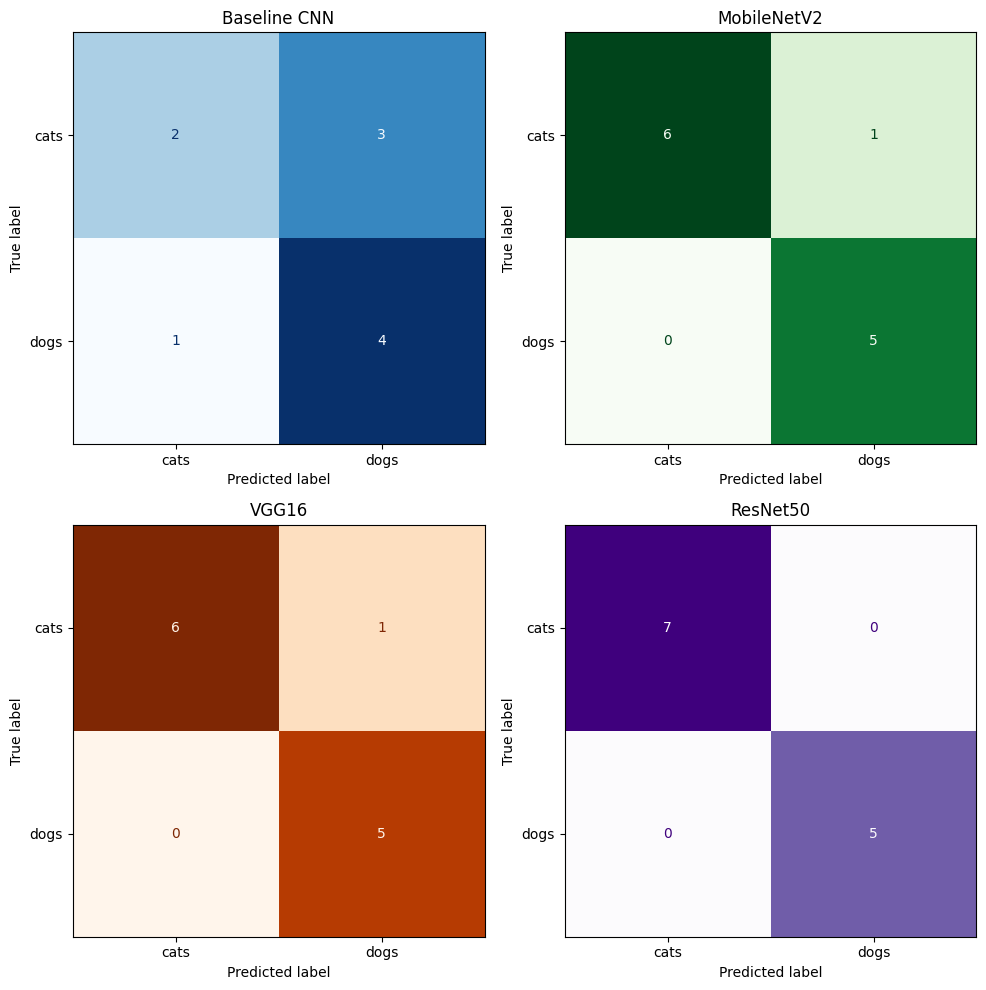

In [68]:
# ============================================================
# 12. PORÓWNANIE MACIERZY POMYŁEK
# (możesz od razu pokazać na zajęciach)
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# baseline
ConfusionMatrixDisplay(cm_base, display_labels=val_gen_small.class_indices.keys()).plot(
    ax=axes[0,0], cmap="Blues", colorbar=False
)
axes[0,0].set_title("Baseline CNN")

# mobilenet
ConfusionMatrixDisplay(cm_m, display_labels=val_gen_small.class_indices.keys()).plot(
    ax=axes[0,1], cmap="Greens", colorbar=False
)
axes[0,1].set_title("MobileNetV2")

# vgg
ConfusionMatrixDisplay(cm_v, display_labels=val_gen_small.class_indices.keys()).plot(
    ax=axes[1,0], cmap="Oranges", colorbar=False
)
axes[1,0].set_title("VGG16")

# resnet
ConfusionMatrixDisplay(cm_r, display_labels=val_gen_small.class_indices.keys()).plot(
    ax=axes[1,1], cmap="Purples", colorbar=False
)
axes[1,1].set_title("ResNet50")

plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# 13. ANALIZA BŁĘDÓW - WYŚWIETLENIE ŹLE ROZPOZNANYCH OBRAZÓW
# ============================================================

def show_misclassified_images(generator, y_true, y_pred, model_name, max_images=6):
    """
    Wyświetla źle sklasyfikowane obrazy z prawdziwymi i przewidzianymi etykietami
    """
    # Znajdź indeksy błędnie sklasyfikowanych obrazów
    misclassified_indices = np.where(y_true != y_pred)[0]
    
    if len(misclassified_indices) == 0:
        print(f"{model_name}: Brak błędnie sklasyfikowanych obrazów!")
        return
    
    # Ogranicz liczbę wyświetlanych obrazów
    num_to_show = min(max_images, len(misclassified_indices))
    
    print(f"\n=== {model_name} - Błędnie sklasyfikowane obrazy ({len(misclassified_indices)} z {len(y_true)}) ===")
    
    # Reset generatora i pobierz wszystkie batche
    generator.reset()
    all_images = []
    all_labels = []
    
    for i in range(len(generator)):
        batch_x, batch_y = generator[i]
        all_images.extend(batch_x)
        all_labels.extend(batch_y)
    
    # Mapa klas
    class_names = list(generator.class_indices.keys())
    
    # Wyświetl obrazy
    fig, axes = plt.subplots(1, num_to_show, figsize=(4*num_to_show, 4))
    if num_to_show == 1:
        axes = [axes]
    
    for i in range(num_to_show):
        idx = misclassified_indices[i]
        img = all_images[idx]
        true_label = int(y_true[idx])
        pred_label = int(y_pred[idx])
        
        axes[i].imshow(img)
        axes[i].set_title(f"Prawda: {class_names[true_label]}\nPrzewidywanie: {class_names[pred_label]}", 
                         fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Analiza błędów dla każdego modelu
print("ANALIZA BŁĘDÓW - ŹLE ROZPOZNANE OBRAZY WALIDACYJNE")
print("="*60)

# 1. Baseline CNN
show_misclassified_images(val_gen_small, y_true, y_pred, "Baseline CNN")

# 2. MobileNetV2
show_misclassified_images(val_gen_small, y_true, y_pred_m, "MobileNetV2")

# 3. VGG16
show_misclassified_images(vgg_val_gen, y_true, y_pred_v, "VGG16")

# 4. ResNet50
show_misclassified_images(resnet_val_gen, y_true_r, y_pred_r, "ResNet50")

ANALIZA BŁĘDÓW - ŹLE ROZPOZNANE OBRAZY WALIDACYJNE


ValueError: operands could not be broadcast together with shapes (12,) (10,) 

: 